In [33]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

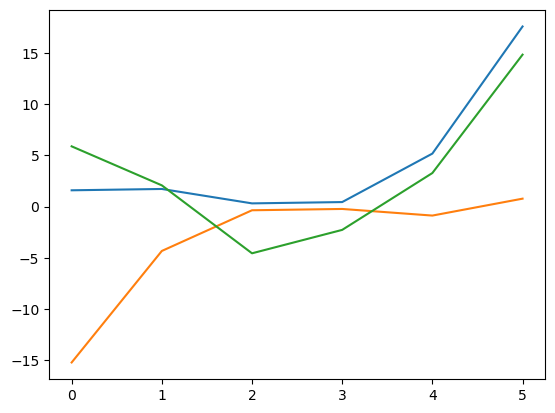

In [106]:
labels = np.linspace(-3,3,1000)
corr_labels = np.tile(labels, (6, 1)).T
# print(corr_labels[:,0])
x = np.linspace(-2,2,6)
corr_data = np.zeros((1000,6))
for i in range(len(corr_data)):
    corr_data[i] = x**3 - corr_labels[i,0]*x**2
plt.plot(corr_data[100])
plt.plot(corr_data[800])
corr_data += 5*np.random.uniform(-1,1, size=corr_data.shape)
plt.plot(corr_data[100])
# plt.plot(corr_data[800])

In [116]:
label_table = np.loadtxt("CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt", skiprows=1, usecols=range(1, 7))

d = np.load("../wgplus_data.npz")
# dictionary
axes = ['x', 'y', 'z']
wgplusses = {axis: d[axis] for axis in axes}

# Example: Access the 250th row, 4th column of the 'x' axis
print(label_table.shape)
print(wgplusses['x'].shape)
corr_data = np.array(wgplusses['x'])
corr_data = np.append(corr_data, np.append(wgplusses['y'],wgplusses['z'],axis=0),axis=0)
corr_labels = np.repeat(label_table, 3, axis=0)
print(corr_data.shape, corr_labels.shape)

(1000, 6)
(1000, 6)
(3000, 6) (3000, 6)


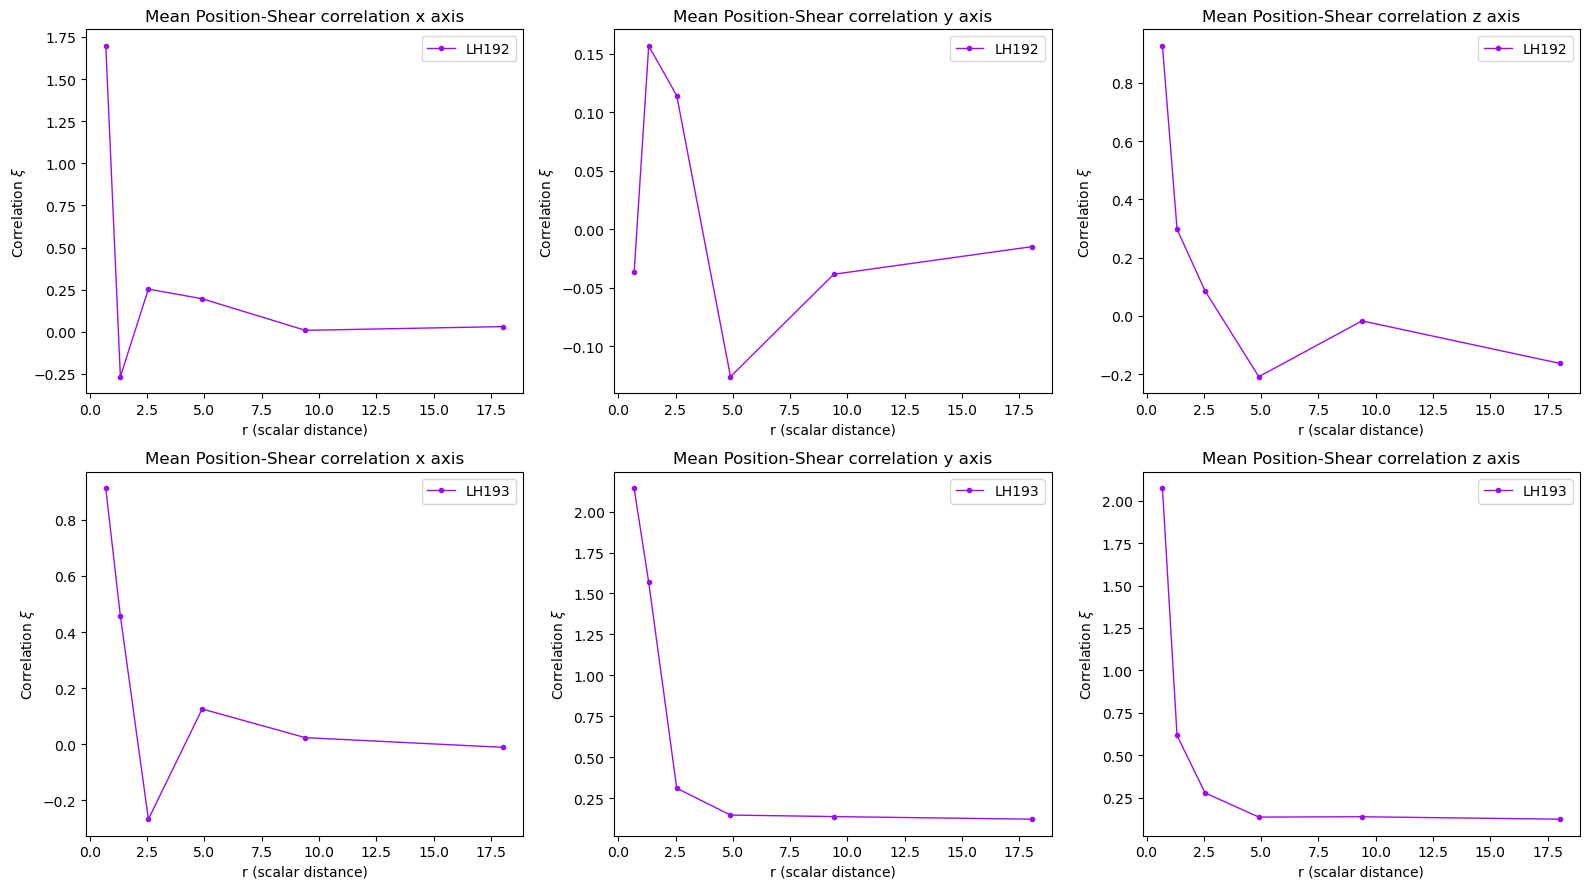

In [117]:
fig, ax = plt.subplots(2, 3,figsize=(16, 9))
r = np.array([ 0.69270901,  1.32957397,  2.55196182,  4.8981924 ,  9.40150773, 18.04509509])
for i in range(2):
    for j in range(3):
        ax[i,j].errorbar(r,wgplusses[axes[j]][i+184],color='xkcd:violet',lw=1,
             label=f'LH{i+192}', fmt = '.-')
        #ax[i,j].set_ylim([-0.035,0.01])
        ax[i,j].set_xlabel(r'r (scalar distance)')
        ax[i,j].set_ylabel(r'Correlation $\xi$')
        ax[i,j].set_title(f'Mean Position-Shear correlation {axes[j]} axis')
        ax[i,j].legend()
plt.tight_layout()

In [118]:
# Get the number of samples (dimension along the first axis)
num_samples = corr_data.shape[0]
# Generate a random permutation of indices
random_indices = np.random.permutation(num_samples)
# Shuffle both arrays using the same permutation
corr_data = corr_data[random_indices]
corr_labels = corr_labels[random_indices]

In [119]:
mean_labels = np.mean(corr_labels,axis=0)
std_labels = np.std(corr_labels,axis=0)
print(mean_labels)
print(std_labels)
renorm_labels = (corr_labels-mean_labels) / (std_labels*5)  #+ 0.5 # mean of 0.5, std of 0.2

mean_corrs = np.mean(corr_data)
std_corrs = np.std(corr_data)
print(mean_corrs)
print(std_corrs)
renorm_corrs = (corr_data-mean_corrs)/(std_corrs*5)  # mean of 0, std of 0.2

[0.3        0.8        1.35252612 1.35252612 1.08202118 1.08202118]
[0.11547    0.11547    1.02214894 1.02214894 0.42632871 0.42632871]
0.4660289334425547
1.3884905298556731


Text(0, 0.5, 'Frequency')

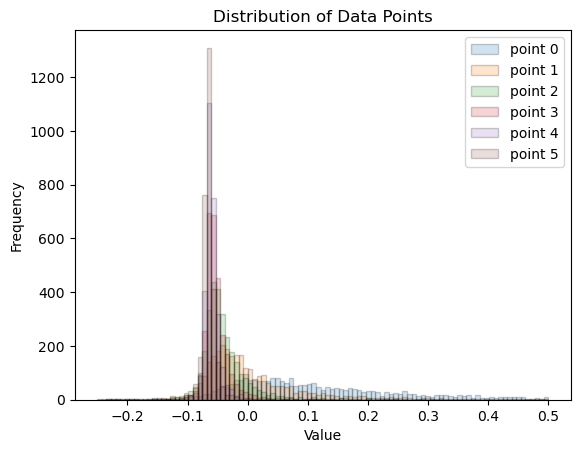

In [120]:
for i in [0,1,2,3,4,5]:
    plt.hist(renorm_corrs[:,i], bins=np.linspace(-0.25,0.5,100), edgecolor='black',alpha=0.2, label=f'point {i}')
plt.legend()
plt.title(f'Distribution of Data Points')
plt.xlabel('Value')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

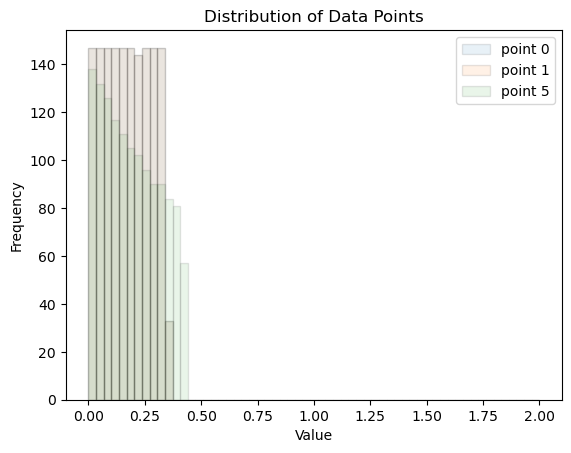

In [121]:
for i in [0,1,5]:
    plt.hist(renorm_labels[:,i], bins=np.linspace(-0,2,60), edgecolor='black',alpha=0.1, label=f'point {i}')
plt.legend()
plt.title(f'Distribution of Data Points')
plt.xlabel('Value')
plt.ylabel('Frequency')

In [122]:
train_data, test_data, train_label, test_label = train_test_split(renorm_corrs, renorm_labels, test_size = 0.1, random_state = None, shuffle=True)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.05, random_state = None)
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)
print(val_data.shape, val_label.shape)

(2565, 6) (2565, 6)
(300, 6) (300, 6)
(135, 6) (135, 6)


#### Build Model

In [123]:
model = keras.models.Sequential()
#model.add(normalizer)
model.add(tf.keras.layers.Dense(50, input_shape=(6,), activation="relu"))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(50, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(32, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(8, activation='relu'))


# model.add(tf.keras.layers.BatchNormalization())  # Normalization 3
model.add(tf.keras.layers.Dense(1, activation='tanh'))
#model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4))
model.build()
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 50)                350       
                                                                 
 dense_61 (Dense)            (None, 50)                2550      
                                                                 
 dense_62 (Dense)            (None, 32)                1632      
                                                                 
 dense_63 (Dense)            (None, 8)                 264       
                                                                 
 dense_64 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4805 (18.77 KB)
Trainable params: 4805 (18.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [124]:
param=0
pre_test_predict=model.predict(test_data, verbose=1)
history=model.fit(train_data,train_label[:,param],epochs=20,batch_size=32,verbose=1,validation_data=(val_data,val_label[:,param]))

10/10 [==============================] - 0s 399us/step
Epoch 1/20
81/81 [==============================] - 0s 788us/step - loss: 0.0398 - val_loss: 0.0449
Epoch 2/20
81/81 [==============================] - 0s 445us/step - loss: 0.0395 - val_loss: 0.0452
Epoch 3/20
81/81 [==============================] - 0s 415us/step - loss: 0.0396 - val_loss: 0.0450
Epoch 4/20
81/81 [==============================] - 0s 406us/step - loss: 0.0395 - val_loss: 0.0449
Epoch 5/20
81/81 [==============================] - 0s 405us/step - loss: 0.0396 - val_loss: 0.0449
Epoch 6/20
81/81 [==============================] - 0s 400us/step - loss: 0.0395 - val_loss: 0.0450
Epoch 7/20
81/81 [==============================] - 0s 413us/step - loss: 0.0395 - val_loss: 0.0451
Epoch 8/20
81/81 [==============================] - 0s 408us/step - loss: 0.0394 - val_loss: 0.0448
Epoch 9/20
81/81 [==============================] - 0s 401us/step - loss: 0.0394 - val_loss: 0.0449
Epoch 10/20
81/81 [==========================

End validation loss is: 0.04514765366911888


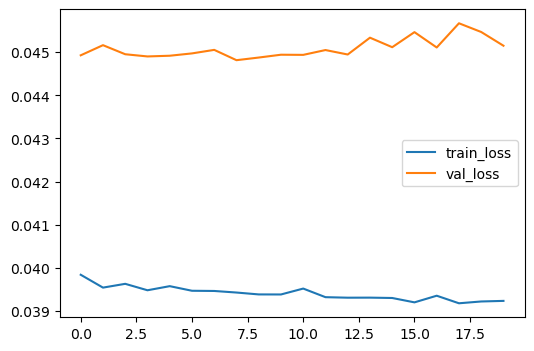

In [125]:
print("End validation loss is:", history.history['val_loss'][-1])
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

81/81 [==============================] - 0s 639us/step


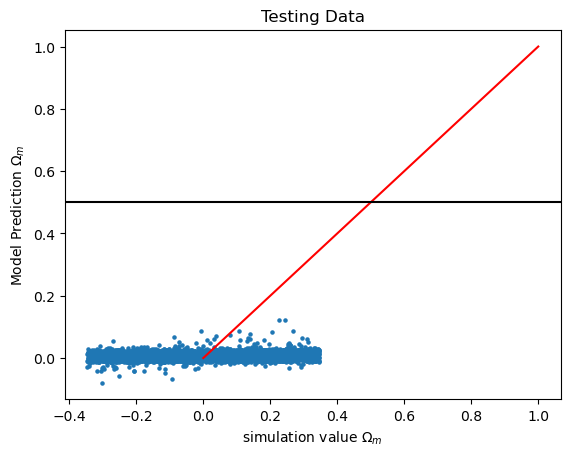

In [126]:
simpars = ['\Omega_m','\sigma_8','A_{SN1}','A_{SN2}','A_{AGN1}','A_{AGN2}']
lims = [[0.1,0.5],[0.6,1.0],np.log([0.25,4.0]),np.log([0.5,2.0]),np.log([0.5,2.0]),np.log([0.5,2.0])]
test_predict=model.predict(train_data, verbose=1)
plt.plot([0,1],[0,1],c='r')
plt.scatter(train_label[:,param], test_predict,s=5)
# plt.ylim([np.min(test_label[:,param]),np.max(test_label[:,param])])
# plt.xlim([np.min(test_label[:,param]),np.max(test_label[:,param])])
plt.ylabel(f'Model Prediction ${simpars[param]}$')
plt.xlabel(f'simulation value ${simpars[param]}$')
plt.title('Testing Data')
plt.axhline(0.5,c='k')

#### Bootstrap sampling

In [8]:
num_samples, bins = corr_data.shape
num_resamples = 100


In [9]:
np.random.choice()

6